# **Data Cleaning**

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/Dataset.csv", low_memory=False)


missing_markers = ["?", "NA", "N/A", " ", ""]
df.replace(missing_markers, np.nan, inplace=True)


numeric_cols = [
    'USMER','MEDICAL_UNIT','SEX','PATIENT_TYPE','INTUBED','PNEUMONIA','AGE',
    'PREGNANT','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE',
    'CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO',
    'CLASIFFICATION_FINAL','ICU'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if "DATE_DIED" in df.columns:
    df["DATE_DIED"] = pd.to_datetime(df["DATE_DIED"], format="%d-%m-%Y", errors="coerce")
    df["DIED"] = df["DATE_DIED"].notna().astype(int)

invalid_codes = [97, 98, 99]
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].replace(invalid_codes, np.nan)

df = df.applymap(lambda x: np.random.choice([1, 2]) if pd.isna(x) else x)

output_path = "/content/cleaned_Dataset.csv"
df.to_csv(output_path, index=False)

print("Cleaned dataset saved as:", output_path)

Cleaned dataset saved as: /content/cleaned_Dataset.csv


# **Exploratory Data Analysis (EDA)**

**Distribution of target variable (ICU)**

Dataset shape: (192543, 23)

Columns: ['INDEX', 'USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU', 'DIED']


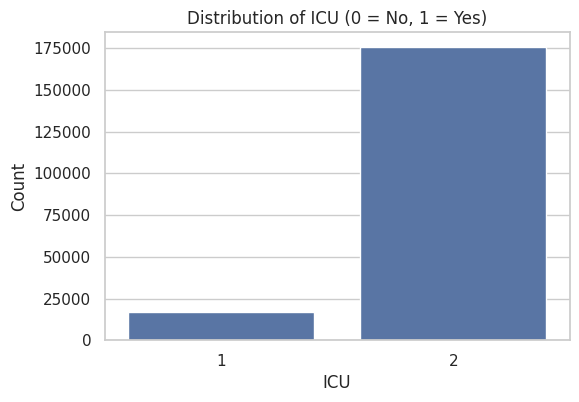


ICU Class Balance (%):
ICU
2    91.244553
1     8.755447
Name: proportion, dtype: float64


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/cleaned_Dataset.csv")

sns.set(style="whitegrid")

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

plt.figure(figsize=(6,4))
sns.countplot(x='ICU', data=df)
plt.title("Distribution of ICU (0 = No, 1 = Yes)")
plt.xlabel("ICU")
plt.ylabel("Count")
plt.show()

print("\nICU Class Balance (%):")
print(df['ICU'].value_counts(normalize=True) * 100)

**Count of ICU cases vs Age**

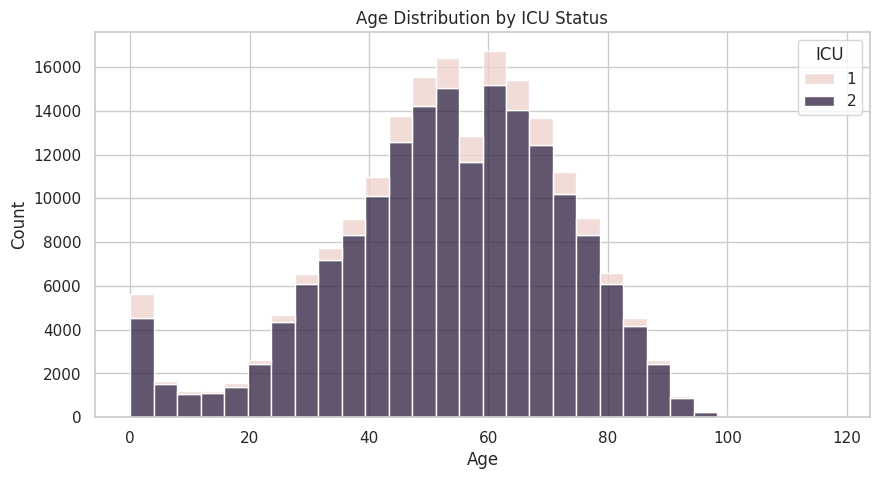

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='AGE', hue='ICU', bins=30, multiple='stack')
plt.title("Age Distribution by ICU Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

**ICU count vs CLASIFFICATION_FINAL**

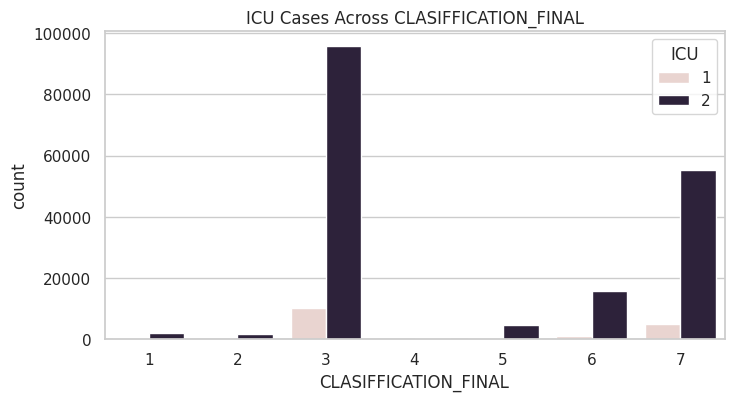

In [20]:
if 'CLASIFFICATION_FINAL' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x='CLASIFFICATION_FINAL', hue='ICU', data=df)
    plt.title("ICU Cases Across CLASIFFICATION_FINAL")
    plt.show()

Scatter matrix (select only useful numeric columns)

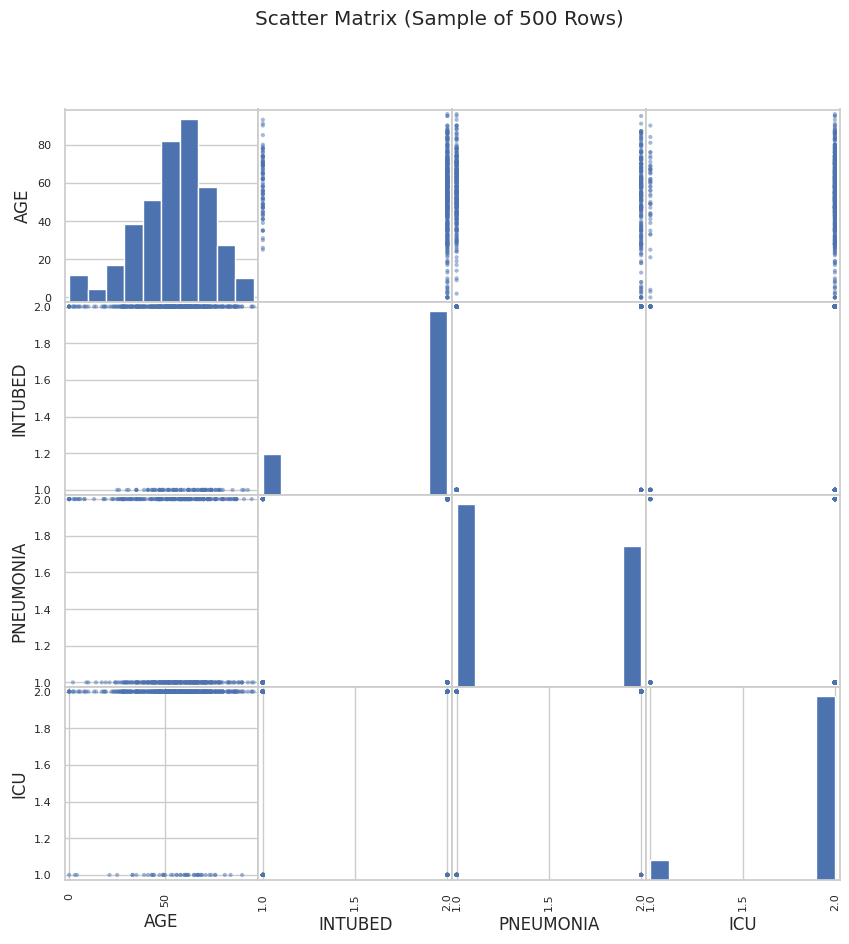

In [21]:
from pandas.plotting import scatter_matrix

selected_cols = ['AGE','INTUBED','PNEUMONIA','ICU']
selected_cols = [c for c in selected_cols if c in df.columns]

sample_df = df[selected_cols].sample(500)

scatter_matrix(sample_df, figsize=(10,10), diagonal='hist')
plt.suptitle("Scatter Matrix (Sample of 500 Rows)")
plt.show()

Correlation matrix (NUMERIC ONLY)

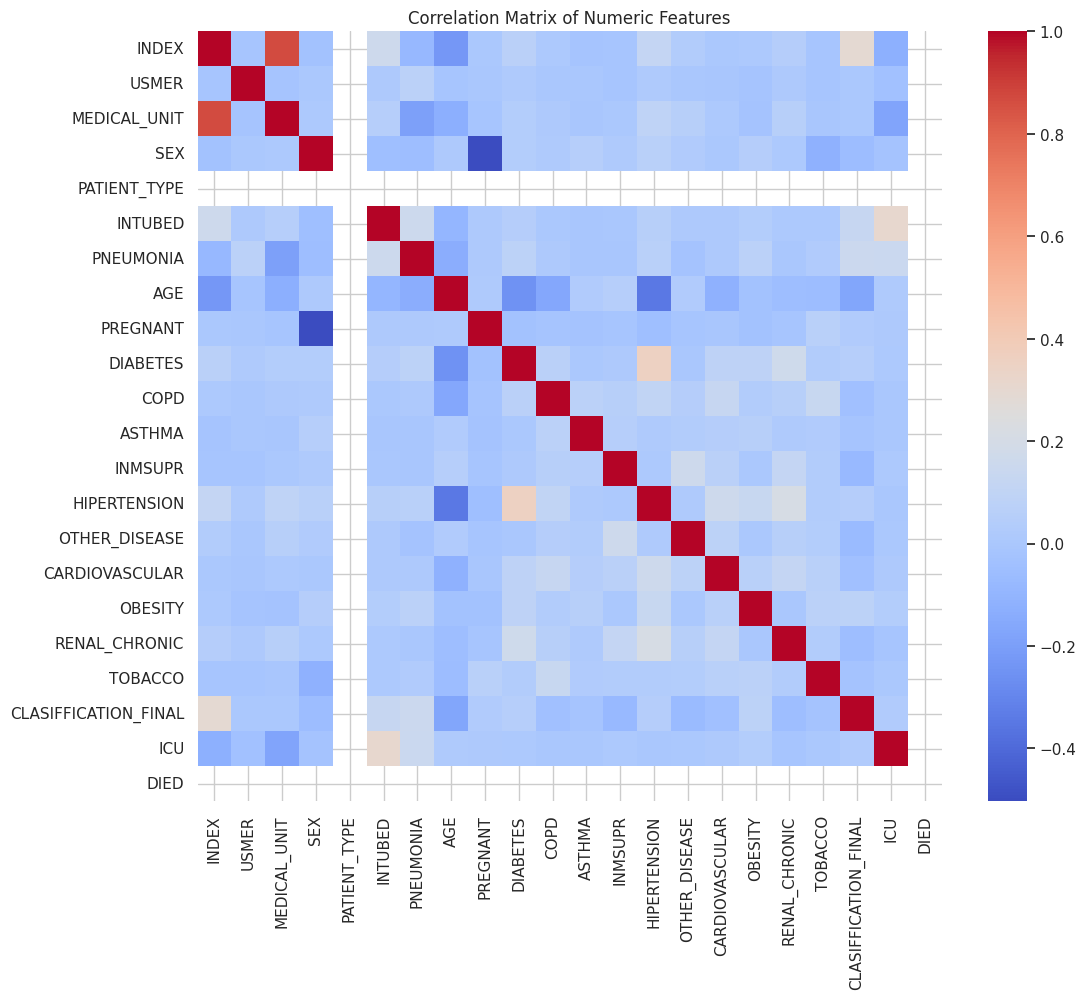

In [23]:
numeric_df = df.select_dtypes(include=["number"])

plt.figure(figsize=(12,10))
corr = numeric_df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

**Additional recommended plots**

ICU vs Obesity

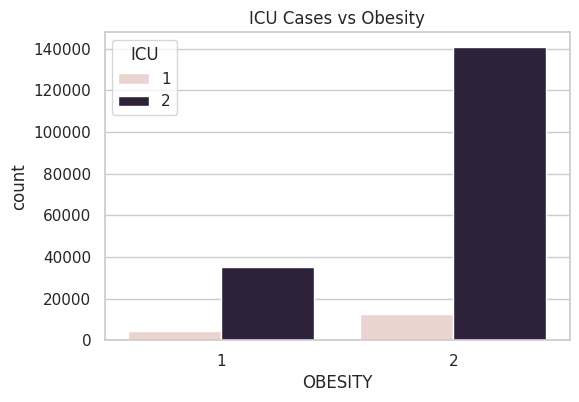

In [24]:
if 'OBESITY' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='OBESITY', hue='ICU', data=df)
    plt.title("ICU Cases vs Obesity")
    plt.show()

ICU vs Hypertension

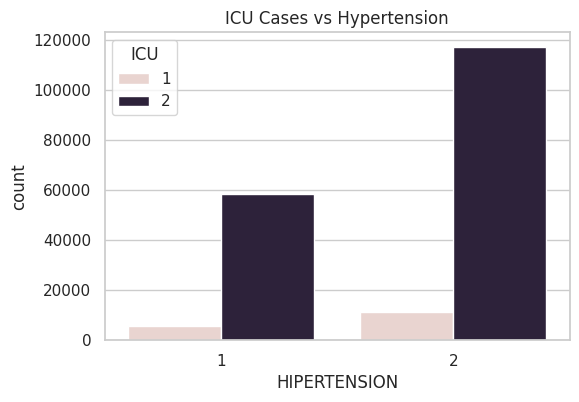

In [25]:
if 'HIPERTENSION' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='HIPERTENSION', hue='ICU', data=df)
    plt.title("ICU Cases vs Hypertension")
    plt.show()

ICU vs Renal Chronic

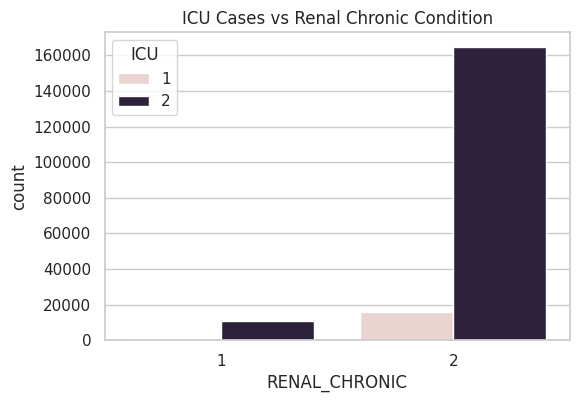

In [26]:
if 'RENAL_CHRONIC' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='RENAL_CHRONIC', hue='ICU', data=df)
    plt.title("ICU Cases vs Renal Chronic Condition")
    plt.show()

# **Model Building**

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

from imblearn.over_sampling import SMOTE

df = pd.read_csv("/content/cleaned_Dataset.csv")

print("Dataset shape:", df.shape)

# 1. Select Predictor Columns (Features)

drop_cols = ["ICU", "DATE_DIED"]
drop_cols = [c for c in drop_cols if c in df.columns]

numeric_features = df.select_dtypes(include=['number']).columns.tolist()

X_cols = [c for c in numeric_features if c not in drop_cols]

print("\nSelected Features:", X_cols)

X = df[X_cols]
y = df["ICU"]

# 2. Train / Test Split (Stratified because imbalanced)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", X_train.shape)
print("Test size:", X_test.shape)
print("Training class distribution:\n", y_train.value_counts(normalize=True))

# 3. Scale the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Build Baseline Logistic Regression

lr = LogisticRegression(max_iter=1000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring="roc_auc")

print("\nBaseline Cross-Validation ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

# 5. Evaluate Baseline Model

print("\n=== BASELINE MODEL PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# 6. Handle Imbalance using SMOTE (Oversampling)

print("\nApplying SMOTE to balance classes...")
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

print("After SMOTE class distribution:\n", pd.Series(y_resampled).value_counts())

lr_sm = LogisticRegression(max_iter=1000)
lr_sm.fit(X_resampled, y_resampled)

y_pred_sm = lr_sm.predict(X_test_scaled)
y_proba_sm = lr_sm.predict_proba(X_test_scaled)[:, 1]

print("\n=== SMOTE MODEL PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test, y_pred_sm))
print("Precision:", precision_score(y_test, y_pred_sm, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_sm, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_sm, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_sm))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_sm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_sm, zero_division=0))

# 7. Compare Baseline vs SMOTE

print("\n=============== COMPARISON ===============")
print("Baseline Recall:", recall_score(y_test, y_pred))
print("SMOTE Recall:", recall_score(y_test, y_pred_sm))
print("Baseline F1:", f1_score(y_test, y_pred))
print("SMOTE F1:", f1_score(y_test, y_pred_sm))
print("Baseline ROC-AUC:", roc_auc_score(y_test, y_proba))
print("SMOTE ROC-AUC:", roc_auc_score(y_test, y_proba_sm))

Dataset shape: (192543, 23)

Selected Features: ['INDEX', 'USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'DIED']

Train size: (154034, 21)
Test size: (38509, 21)
Training class distribution:
 ICU
2    0.912448
1    0.087552
Name: proportion, dtype: float64

Baseline Cross-Validation ROC-AUC Scores: [0.80678462 0.80060313 0.80495833 0.79948466 0.79508997]
Mean ROC-AUC: 0.8013841402856053

=== BASELINE MODEL PERFORMANCE ===
Accuracy: 0.91329299644239
Precision: 0.5178764897074756
Recall: 0.1417556346381969
F1 Score: 0.22258440046565775
ROC-AUC: 0.8136740457813477

Confusion Matrix:
 [[  478  2894]
 [  445 34692]]

Classification Report:
               precision    recall  f1-score   support

           1       0.52      0.14      0.22      3372
           2       0.92      0.99      0.95     

# **Part-2 — Improved Model**

## Load RAW Dataset and Soft Cleaning (Imputation)

In [31]:
import pandas as pd
import numpy as np

# Load original dataset
df = pd.read_csv("/content/Dataset.csv", low_memory=False)

print("Original shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# 1. Convert missing markers to NaN
missing_markers = ["?", "NA", "N/A", " ", ""]
df.replace(missing_markers, np.nan, inplace=True)

# 2. Convert numeric columns
numeric_cols = [
    'USMER','MEDICAL_UNIT','SEX','PATIENT_TYPE','INTUBED','PNEUMONIA','AGE',
    'PREGNANT','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE',
    'CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO',
    'CLASIFFICATION_FINAL','ICU'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace invalid codes (97/98/99)
invalid_codes = [97, 98, 99]
for col in numeric_cols:
    df[col] = df[col].replace(invalid_codes, np.nan)

# 3. Convert DATE_DIED + DIED flag
df["DATE_DIED"] = pd.to_datetime(df["DATE_DIED"], format="%d-%m-%Y", errors="coerce")
df["DIED"] = df["DATE_DIED"].notna().astype(int)

# 4. IMPUTE missing values instead of dropping
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

print("\nRemaining NaNs after imputation:")
print(df.isna().sum())

Original shape: (192543, 23)

Columns: ['INDEX', 'USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU', 'DIED']

Remaining NaNs after imputation:
INDEX                   0
USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
DIED                    0
dtype: int64


In [32]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score
)

# Select features
drop_cols = ["ICU", "DATE_DIED"]
X_cols = [c for c in numeric_cols if c not in drop_cols]

X = df[X_cols]
y = df["ICU"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

print("\n=== Logistic Regression (Improved Data) ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("F1:", f1_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Random Forest Model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("\n=== Random Forest (Improved Data) ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))



=== Logistic Regression (Improved Data) ===
ROC-AUC: 0.8133137884176194
F1: 0.23259020914732245
Recall: 0.15005931198102015
Accuracy: 0.91329299644239

=== Random Forest (Improved Data) ===
ROC-AUC: 0.7913444952684952
F1: 0.3754831584759801
Recall: 0.302491103202847
Accuracy: 0.9118907268430756


## K-Means Clustering + Visualization

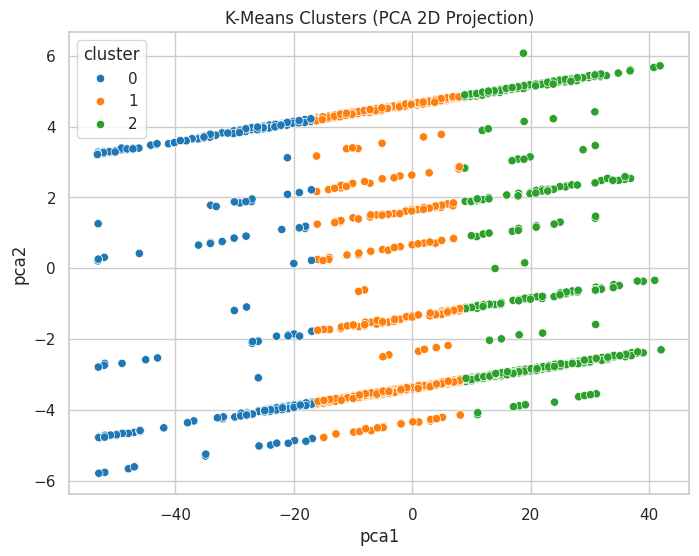


ICU distribution per cluster:
cluster  ICU
0        2      0.905798
         1      0.094202
1        2      0.913935
         1      0.086065
2        2      0.913897
         1      0.086103
Name: proportion, dtype: float64


In [33]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# PCA for 2D visualization
# -----------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_cluster = df.copy()
df_cluster["pca1"] = X_pca[:,0]
df_cluster["pca2"] = X_pca[:,1]

# -----------------------------
# Perform K-Means (k=3)
# -----------------------------
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(X)

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cluster.sample(2000), x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("K-Means Clusters (PCA 2D Projection)")
plt.show()

# ICU distribution per cluster
print("\nICU distribution per cluster:")
print(df_cluster.groupby("cluster")["ICU"].value_counts(normalize=True))

## Cluster-Based Local Classifiers

In [34]:
from sklearn.linear_model import LogisticRegression

print("\n=== Cluster-Based Local Classifiers ===")

cluster_models = {}

for c in range(k):
    sub = df_cluster[df_cluster["cluster"] == c]
    if len(sub) < 50:
        print(f"Cluster {c}: Too small for model")
        continue

    Xc = sub[X_cols]
    yc = sub["ICU"]

    # Train/test split inside cluster
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(
        Xc, yc, test_size=0.2, random_state=42, stratify=yc
    )

    scaler = StandardScaler()
    Xc_train_scaled = scaler.fit_transform(Xc_train)
    Xc_test_scaled = scaler.transform(Xc_test)

    model = LogisticRegression(max_iter=1000)
    model.fit(Xc_train_scaled, yc_train)

    y_pred_c = model.predict(Xc_test_scaled)

    print(f"\nCluster {c} — F1 Score:", f1_score(yc_test, y_pred_c))
    cluster_models[c] = model


=== Cluster-Based Local Classifiers ===

Cluster 0 — F1 Score: 0.3776824034334764

Cluster 1 — F1 Score: 0.22487562189054727

Cluster 2 — F1 Score: 0.20647773279352227


# PySpark Version

In [36]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("ICU_Risk").getOrCreate()

# Load original dataset
df_spark = spark.read.csv("/content/Dataset.csv", header=True, inferSchema=True)

# Replace "?" with null
for c in df_spark.columns:
    df_spark = df_spark.withColumn(c, when(col(c) == "?", None).otherwise(col(c)))

# Convert target to numeric
indexer = StringIndexer(inputCol="ICU", outputCol="ICU_index")
df_spark = indexer.fit(df_spark).transform(df_spark)

# Create feature vector
feature_cols = [c for c in df_spark.columns if c not in ("ICU", "ICU_index", "DATE_DIED")]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Logistic Regression
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="ICU_index")

pipeline = Pipeline(stages=[assembler, scaler, lr])
model = pipeline.fit(df_spark)
print("PySpark model training complete.")

PySpark model training complete.
